In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time
%matplotlib inline

In [2]:
torch.__version__

'2.0.1'

In [3]:
import sys
sys.version

'3.10.11 (main, Apr 20 2023, 19:02:41) [GCC 11.2.0]'

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using gpu: {torch.cuda.is_available()}", )

Using gpu: True


In [5]:
if os.path.exists("dogscats") and os.path.isdir("dogscats"):
    pass
else:
    !mkdir dogscats
    !cd dogscats
    !wget http://files.fast.ai/data/examples/dogscats.tgz
    !tar -zxvf dogscats.tgz

In [6]:
%ls

README.md                         pandas.ipynb
brain-tumor-classification.ipynb  plant_species.ipynb
dogscats/                         pytorch_tensors.ipynb
dogscats.tgz                      using-cnn-for-dogs-vs-cats-clean.ipynb
matplotlib.ipynb                  using-cnn-for-dogs-vs-cats.ipynb


In [7]:
%cd dogscats/
%ls

/home/gradients/dogscats
imagenet_class_index.json    imagenet_class_index.json.2  sample/  train/
imagenet_class_index.json.1  imagenet_class_index.json.3  test1/   valid/


In [8]:
data_dir = "/home/gradients/dogscats"

In [9]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
imagenet_format = transforms.Compose([
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,
            ])

In [10]:
dsets = {
            x: datasets.ImageFolder(os.path.join(data_dir, x), imagenet_format) for x in ["train", "valid"]
        }

In [11]:
os.path.join(data_dir,'train')

'/home/gradients/dogscats/train'

In [12]:
?datasets.ImageFolder

Init signature:
datasets.ImageFolder(
    root: str,
    transform: Optional[Callable] = None,
    target_transform: Optional[Callable] = None,
    loader: Callable[[str], Any] = <function default_loader at 0x7fcc30f51090>,
    is_valid_file: Optional[Callable[[str], bool]] = None,
)
Docstring:     
A generic data loader where the images are arranged in this way by default: ::

    root/dog/xxx.png
    root/dog/xxy.png
    root/dog/[...]/xxz.png

    root/cat/123.png
    root/cat/nsdf3.png
    root/cat/[...]/asd932_.png

This class inherits from :class:`~torchvision.datasets.DatasetFolder` so
the same methods can be overridden to customize the dataset.

Args:
    root (string): Root directory path.
    transform (callable, optional): A function/transform that  takes in an PIL image
        and returns a transformed version. E.g, ``transforms.RandomCrop``
    target_transform (callable, optional): A function/transform that takes in the
        target and transforms it.
    loader (calla

In [13]:
dsets["train"].classes

['cats', 'dogs']

In [14]:
dsets["train"].class_to_idx

{'cats': 0, 'dogs': 1}

In [15]:
dsets['train'].imgs[:5]

[('/home/gradients/dogscats/train/cats/cat.0.jpg', 0),
 ('/home/gradients/dogscats/train/cats/cat.1.jpg', 0),
 ('/home/gradients/dogscats/train/cats/cat.10.jpg', 0),
 ('/home/gradients/dogscats/train/cats/cat.100.jpg', 0),
 ('/home/gradients/dogscats/train/cats/cat.1000.jpg', 0)]

In [16]:
dset_sizes = {x: len(dsets[x]) for x in ["train", "valid"]}
dset_sizes

{'train': 23000, 'valid': 2000}

In [17]:
dset_classes = dsets["train"].classes

In [18]:
?imagenet_format

Signature:   imagenet_format(img)
Type:        Compose
String form:
Compose(
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
File:        /opt/conda/lib/python3.10/site-packages/torchvision/transforms/transforms.py
Docstring:  
Composes several transforms together. This transform does not support torchscript.
Please, see the note below.

Args:
    transforms (list of ``Transform`` objects): list of transforms to compose.

Example:
    >>> transforms.Compose([
    >>>     transforms.CenterCrop(10),
    >>>     transforms.PILToTensor(),
    >>>     transforms.ConvertImageDtype(torch.float),
    >>> ])

.. note::
    In order to script the transformations, please use ``torch.nn.Sequential`` as below.

    >>> transforms = torch.nn.Sequential(
    >>>     transforms.CenterCrop(10),
    >>>     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    >>> )
    >>> scripted_transforms = torch.jit.script(tran

In [19]:
loader_train = torch.utils.data.DataLoader(dsets["train"], batch_size=64, shuffle=True, num_workers=6)

In [20]:
?torch.utils.data.DataLoader

Init signature:
torch.utils.data.DataLoader(
    dataset: torch.utils.data.dataset.Dataset[+T_co],
    batch_size: Optional[int] = 1,
    shuffle: Optional[bool] = None,
    sampler: Union[torch.utils.data.sampler.Sampler, Iterable, NoneType] = None,
    batch_sampler: Union[torch.utils.data.sampler.Sampler[Sequence], Iterable[Sequence], NoneType] = None,
    num_workers: int = 0,
    collate_fn: Optional[Callable[[List[~T]], Any]] = None,
    pin_memory: bool = False,
    drop_last: bool = False,
    timeout: float = 0,
    worker_init_fn: Optional[Callable[[int], NoneType]] = None,
    multiprocessing_context=None,
    generator=None,
    *,
    prefetch_factor: Optional[int] = None,
    persistent_workers: bool = False,
    pin_memory_device: str = '',
)
Docstring:     
Data loader. Combines a dataset and a sampler, and provides an iterable over
the given dataset.

The :class:`~torch.utils.data.DataLoader` supports both map-style and
iterable-style datasets with single- or multi-pro

In [21]:
loader_valid = torch.utils.data.DataLoader(dsets["valid"], batch_size=8, shuffle=False, num_workers=6)

In [22]:
count = len(loader_valid)
count

250

In [23]:
inputs_try, labels_try = next(iter(loader_valid))
inputs_try, labels_try

(tensor([[[[ 1.1529,  1.1015,  1.0502,  ..., -1.4672, -1.4500, -1.4329],
           [ 1.0673,  1.0159,  0.9817,  ..., -1.4329, -1.4158, -1.3987],
           [ 0.9474,  0.9132,  0.8961,  ..., -1.4329, -1.4329, -1.4329],
           ...,
           [-1.6042, -1.5870, -1.5699,  ...,  0.8447,  0.7933,  0.7248],
           [-1.5528, -1.5528, -1.5699,  ...,  0.9303,  0.8961,  0.8789],
           [-1.5185, -1.5357, -1.5357,  ...,  0.9132,  0.8618,  0.8447]],
 
          [[ 0.8179,  0.7654,  0.7129,  ...,  0.8880,  0.9055,  0.9230],
           [ 0.6779,  0.6254,  0.5903,  ...,  0.9230,  0.9405,  0.9580],
           [ 0.5553,  0.5203,  0.5028,  ...,  0.9230,  0.9230,  0.9230],
           ...,
           [ 0.8529,  0.8704,  0.8880,  ...,  0.3978,  0.3452,  0.2752],
           [ 0.9580,  0.9055,  0.8880,  ...,  0.5203,  0.4853,  0.4503],
           [ 0.9930,  0.9755,  0.9230,  ...,  0.5203,  0.4678,  0.4503]],
 
          [[ 0.1999,  0.1651,  0.1128,  ...,  0.1128,  0.1302,  0.1476],
           [ 

In [24]:
inputs_try.shape

torch.Size([8, 3, 224, 224])

In [25]:
inputs_try[0]

tensor([[[ 1.1529,  1.1015,  1.0502,  ..., -1.4672, -1.4500, -1.4329],
         [ 1.0673,  1.0159,  0.9817,  ..., -1.4329, -1.4158, -1.3987],
         [ 0.9474,  0.9132,  0.8961,  ..., -1.4329, -1.4329, -1.4329],
         ...,
         [-1.6042, -1.5870, -1.5699,  ...,  0.8447,  0.7933,  0.7248],
         [-1.5528, -1.5528, -1.5699,  ...,  0.9303,  0.8961,  0.8789],
         [-1.5185, -1.5357, -1.5357,  ...,  0.9132,  0.8618,  0.8447]],

        [[ 0.8179,  0.7654,  0.7129,  ...,  0.8880,  0.9055,  0.9230],
         [ 0.6779,  0.6254,  0.5903,  ...,  0.9230,  0.9405,  0.9580],
         [ 0.5553,  0.5203,  0.5028,  ...,  0.9230,  0.9230,  0.9230],
         ...,
         [ 0.8529,  0.8704,  0.8880,  ...,  0.3978,  0.3452,  0.2752],
         [ 0.9580,  0.9055,  0.8880,  ...,  0.5203,  0.4853,  0.4503],
         [ 0.9930,  0.9755,  0.9230,  ...,  0.5203,  0.4678,  0.4503]],

        [[ 0.1999,  0.1651,  0.1128,  ...,  0.1128,  0.1302,  0.1476],
         [ 0.0779,  0.0431,  0.0082,  ...,  0

In [26]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(std * inp + mean, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

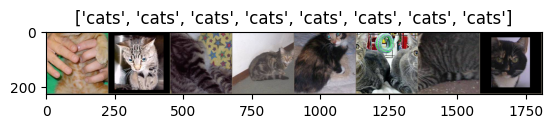

In [27]:
out = torchvision.utils.make_grid(inputs_try)

imshow(out, title=[dset_classes[x] for x in labels_try])

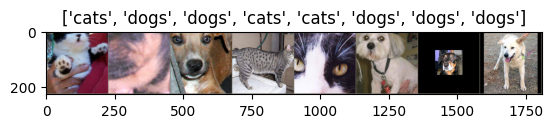

In [28]:
inputs, classes = next(iter(loader_train))

n_images = 8

out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

In [29]:
model_vgg = models.vgg16(weights='DEFAULT')

In [30]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2023-08-30 14:50:05--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.132.120, 52.217.114.56, 52.217.114.216, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.132.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json.4’

imagenet_class_inde 100%[===================>]  34.53K   163KB/s    in 0.2s    

2023-08-30 14:50:07 (163 KB/s) - ‘imagenet_class_index.json.4’ saved [35363/35363]



In [31]:
import json

fpath = '/home/gradients/dogscats/imagenet_class_index.json'

with open(fpath) as f:
    class_dict = json.load(f)
dic_imagenet = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [32]:
dic_imagenet[:4]

['tench', 'goldfish', 'great_white_shark', 'tiger_shark']

In [33]:
inputs_try , labels_try = inputs_try.to(device), labels_try.to(device)

model_vgg = model_vgg.to(device)

In [34]:
outputs_try = model_vgg(inputs_try)

In [35]:
outputs_try

tensor([[ 1.0526, -2.0173, -0.8462,  ...,  2.8267,  4.2603,  0.7641],
        [-1.1720,  1.6166, -2.6550,  ..., -3.4665,  9.2886,  4.8779],
        [-2.1962, -1.8886, -2.6324,  ..., -2.4807,  0.2414,  3.7778],
        ...,
        [-1.3331, -2.1869, -2.0720,  ..., -5.8639,  2.2164,  3.3767],
        [-0.7148, -1.1173, -1.3474,  ..., -3.0799,  1.1560,  4.6380],
        [-0.5859, -0.6711, -1.7469,  ..., -7.2388,  2.9258,  6.8932]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [36]:
outputs_try.shape

torch.Size([8, 1000])

In [37]:
??nn.Softmax

Init signature: nn.Softmax(dim: Optional[int] = None) -> None
Source:        
class Softmax(Module):
    r"""Applies the Softmax function to an n-dimensional input Tensor
    rescaling them so that the elements of the n-dimensional output Tensor
    lie in the range [0,1] and sum to 1.

    Softmax is defined as:

    .. math::
        \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}

    When the input Tensor is a sparse tensor then the unspecified
    values are treated as ``-inf``.

    Shape:
        - Input: :math:`(*)` where `*` means, any number of additional
          dimensions
        - Output: :math:`(*)`, same shape as the input

    Returns:
        a Tensor of the same dimension and shape as the input with
        values in the range [0, 1]

    Args:
        dim (int): A dimension along which Softmax will be computed (so every slice
            along dim will sum to 1).

    .. note::
        This module doesn't work directly with NLLLoss,
        which expects

In [38]:
??model_vgg

Signature:       model_vgg(*args, **kwargs)
Type:            VGG
String form:    
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReL

In [39]:
m_softm = nn.Softmax(dim=1)
probs = m_softm(outputs_try)
vals_try,preds_try = torch.max(probs,dim=1)

In [40]:
torch.sum(probs,1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0', grad_fn=<SumBackward1>)

In [41]:
vals_try

tensor([0.1556, 0.5776, 0.5077, 0.8269, 0.4248, 0.4176, 0.7800, 0.4578],
       device='cuda:0', grad_fn=<MaxBackward0>)

In [42]:
print([dic_imagenet[i] for i in preds_try.data])

['hamster', 'tabby', 'tabby', 'tabby', 'black-footed_ferret', 'tabby', 'tabby', 'Egyptian_cat']


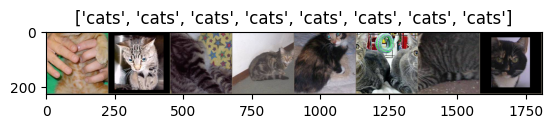

In [43]:
out = torchvision.utils.make_grid(inputs_try.data.cpu())

imshow(out, title=[dset_classes[x] for x in labels_try.data.cpu()])

In [44]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [45]:
for param in model_vgg.parameters():
    param.requires_grad = False
model_vgg.classifier._modules['6'] = nn.Linear(4096, 2)
model_vgg.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)

In [46]:
model_vgg = model_vgg.to(device)

In [47]:
criterion = nn.NLLLoss()
lr = 0.001
optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr)

In [48]:
def train_model(model,dataloader,size,epochs=1,optimizer=None):
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in dataloader:
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            loss = criterion(outputs,classes)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.data.item() / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))

In [49]:
%%time
train_model(model_vgg,loader_train,size=dset_sizes['train'],epochs=2,optimizer=optimizer_vgg)

Loss: 0.0023 Acc: 0.9509
Loss: 0.0013 Acc: 0.9723
CPU times: user 2min 4s, sys: 6.78 s, total: 2min 11s
Wall time: 2min 46s


In [50]:
def test_model(model,dataloader,size):
    model.eval()
    predictions = np.zeros(size)
    all_classes = np.zeros(size)
    all_proba = np.zeros((size,2))
    i = 0
    running_loss = 0.0
    running_corrects = 0
    for inputs,classes in dataloader:
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        loss = criterion(outputs,classes)           
        _,preds = torch.max(outputs.data,1)
            # statistics
        running_loss += loss.data.item()
        running_corrects += torch.sum(preds == classes.data)
        predictions[i:i+len(classes)] = preds.to('cpu').numpy()
        all_classes[i:i+len(classes)] = classes.to('cpu').numpy()
        all_proba[i:i+len(classes),:] = outputs.data.to('cpu').numpy()
        i += len(classes)
    epoch_loss = running_loss / size
    epoch_acc = running_corrects.data.item() / size
    print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))
    return predictions, all_proba, all_classes

In [51]:
predictions, all_proba, all_classes = test_model(model_vgg,loader_valid,size=dset_sizes['valid'])

Loss: 0.0078 Acc: 0.9795


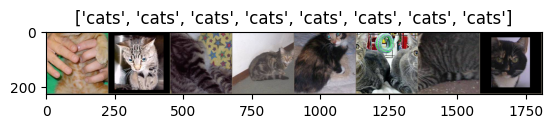

In [52]:
inputs, classes = next(iter(loader_valid))

out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

In [53]:
outputs = model_vgg(inputs[:n_images].to(device))
print(torch.exp(outputs))

tensor([[8.6716e-01, 1.3284e-01],
        [9.9997e-01, 2.8133e-05],
        [9.8993e-01, 1.0068e-02],
        [9.9912e-01, 8.7553e-04],
        [9.9043e-01, 9.5704e-03],
        [9.9941e-01, 5.9163e-04],
        [9.8594e-01, 1.4063e-02],
        [9.9990e-01, 1.0253e-04]], device='cuda:0', grad_fn=<ExpBackward0>)


In [54]:
classes[:n_images]

tensor([0, 0, 0, 0, 0, 0, 0, 0])

In [55]:
x_try = model_vgg.features(inputs_try)

In [56]:
x_try.shape

torch.Size([8, 512, 7, 7])

In [57]:
def preconvfeat(dataloader):
    conv_features = []
    labels_list = []
    for data in dataloader:
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        x = model_vgg.features(inputs)
        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [58]:
%%time
conv_feat_train,labels_train = preconvfeat(loader_train)

CPU times: user 1min 1s, sys: 9.59 s, total: 1min 11s
Wall time: 1min 30s


In [59]:
conv_feat_train.shape

(23000, 512, 7, 7)

In [60]:
%%time
conv_feat_valid,labels_valid = preconvfeat(loader_valid)

CPU times: user 6.95 s, sys: 1.79 s, total: 8.74 s
Wall time: 12.1 s


In [61]:
dtype=torch.float
datasetfeat_train = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_train,labels_train)]
datasetfeat_train = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_train]
loaderfeat_train = torch.utils.data.DataLoader(datasetfeat_train, batch_size=128, shuffle=True)

In [62]:
%%time
train_model(model_vgg.classifier,dataloader=loaderfeat_train,size=dset_sizes['train'],epochs=50,optimizer=optimizer_vgg)

Loss: 0.0006 Acc: 0.9730
Loss: 0.0006 Acc: 0.9735
Loss: 0.0005 Acc: 0.9749
Loss: 0.0005 Acc: 0.9741
Loss: 0.0005 Acc: 0.9754
Loss: 0.0005 Acc: 0.9757
Loss: 0.0005 Acc: 0.9765
Loss: 0.0005 Acc: 0.9769
Loss: 0.0005 Acc: 0.9766
Loss: 0.0005 Acc: 0.9767
Loss: 0.0005 Acc: 0.9778
Loss: 0.0005 Acc: 0.9777
Loss: 0.0005 Acc: 0.9763
Loss: 0.0005 Acc: 0.9755
Loss: 0.0005 Acc: 0.9762
Loss: 0.0005 Acc: 0.9777
Loss: 0.0005 Acc: 0.9769
Loss: 0.0004 Acc: 0.9785
Loss: 0.0005 Acc: 0.9762
Loss: 0.0004 Acc: 0.9777
Loss: 0.0004 Acc: 0.9778
Loss: 0.0004 Acc: 0.9772
Loss: 0.0004 Acc: 0.9782
Loss: 0.0004 Acc: 0.9789
Loss: 0.0004 Acc: 0.9777
Loss: 0.0004 Acc: 0.9779
Loss: 0.0004 Acc: 0.9785
Loss: 0.0004 Acc: 0.9788
Loss: 0.0004 Acc: 0.9793
Loss: 0.0004 Acc: 0.9790
Loss: 0.0004 Acc: 0.9788
Loss: 0.0004 Acc: 0.9796
Loss: 0.0004 Acc: 0.9782
Loss: 0.0004 Acc: 0.9778
Loss: 0.0004 Acc: 0.9792
Loss: 0.0004 Acc: 0.9798
Loss: 0.0004 Acc: 0.9800
Loss: 0.0004 Acc: 0.9799
Loss: 0.0004 Acc: 0.9797
Loss: 0.0004 Acc: 0.9787


In [63]:
datasetfeat_valid = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_valid,labels_valid)]
datasetfeat_valid = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_valid]
loaderfeat_valid = torch.utils.data.DataLoader(datasetfeat_valid, batch_size=128, shuffle=False)

In [64]:
predictions, all_proba, all_classes = test_model(model_vgg.classifier,dataloader=loaderfeat_valid,size=dset_sizes['valid'])

Loss: 0.0003 Acc: 0.9865


In [65]:
n_view = 8

In [66]:
correct = np.where(predictions==all_classes)[0]

In [67]:
len(correct)/dset_sizes['valid']

0.9865

In [68]:
from numpy.random import random, permutation
idx = permutation(correct)[:n_view]

In [69]:
idx

array([   7,  802,  882, 1593,  492, 1054,  158, 1968])

In [70]:
loader_correct = torch.utils.data.DataLoader([dsets['valid'][x] for x in idx],batch_size = n_view,shuffle=True)

In [71]:
for data in loader_correct:
    inputs_cor,labels_cor = data

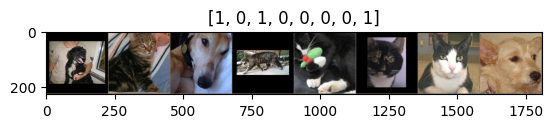

In [72]:
out = torchvision.utils.make_grid(inputs_cor)

imshow(out, title=[l.item() for l in labels_cor])

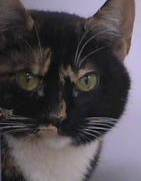

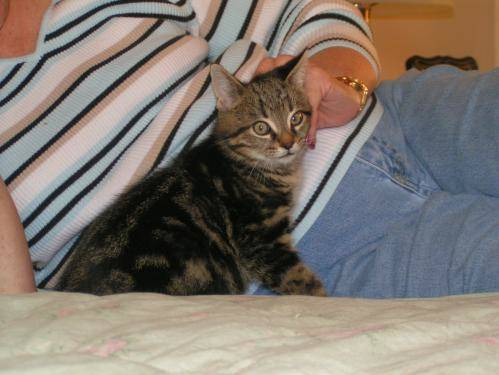

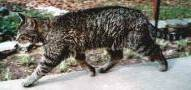

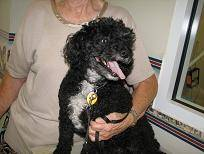

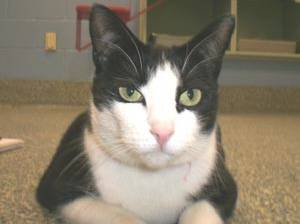

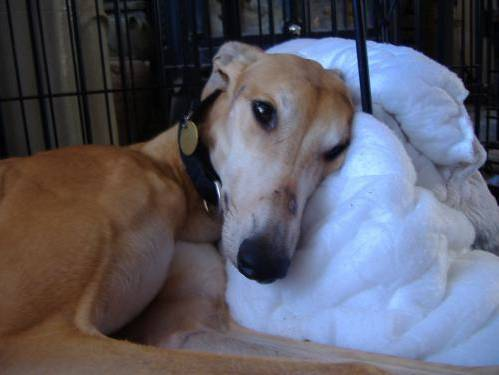

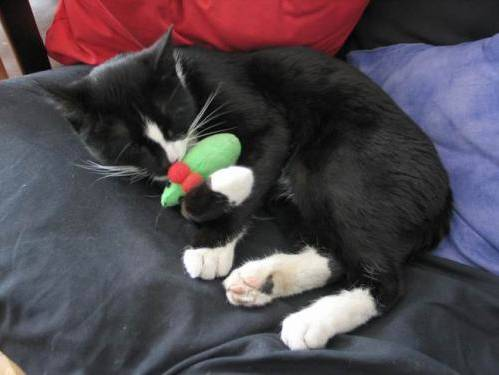

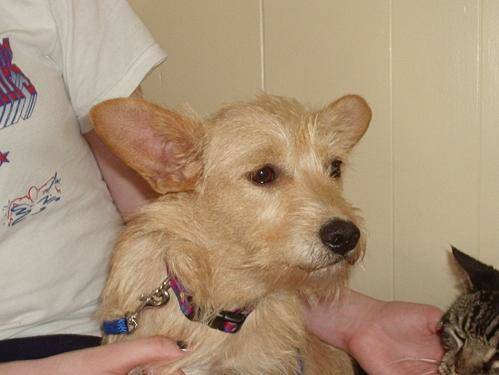

In [73]:
from IPython.display import Image, display
for x in idx:
    display(Image(filename=dsets['valid'].imgs[x][0], retina=True))